## 3D deblending for astronomical data cubes
This notebook provides an example of deblending HI gas in galaxy pairs.   

See the accompanied paper for more details: [Huang et al. 2025](submitted)

## 1. Input files

- cube: HI data cube
- mask: mask cube
- opti: optical image of the same field cut from [DESI Legacy Imaging Surveys](https://www.legacysurvey.org) (It is recommended to use the LAST CELL of this notebook to obtain the optical images.)
- img: RGB image cut from DESI Legacy Imaging Surveys (for visualization only) 

**NOTE:**  
Currently, the code requires that the spaxel size of the data cube is an integral multiple of the pixel size of the optical images.  (Otherwise one should use the package ```reproject``` and modify the code yourself.)  

For example, the spaxel size of our HI data is 6'', so we downgrade the DESI images to 1''.

In [1]:
import numpy as np
import astropy.units as u
from astropy.io import fits
from astropy.coordinates import SkyCoord
import matplotlib.pyplot as plt

In [2]:
# load data
name = "WALLABY_J103540-284607"
cube = fits.open(f"./data/{name}_cube.fits")
mask = fits.open(f"./data/{name}_mask.fits")
opti = fits.open(f"./data/{name}_desi.fits")
img = np.flipud(plt.imread(f"./data/{name}_opt.jpg"))
pix = 6   # 6"/1" = 6

# moment-0 map
mom0 = np.nansum(cube[0].data * mask[0].data, axis=0)
masked_mom0 = np.ma.masked_array(mom0, np.abs(mom0) < 1e-8)

# shape of the data cube
z, h, w = np.shape(cube[0].data)

# coordinate systems (please convert to J2000)
from astropy.wcs import WCS
wcs     = WCS(cube[0].header).celestial
wcs_opt = WCS(opti[0].header).celestial
coords  = wcs.pixel_to_world(w/2-0.5, h/2-0.5)

Now we can display the images to have a first impression of our data. Here we show a trival case that the two galaxies are well separated, and a 2D deblending algorithm (e.g. [_photutils.segmentation.deblend_sources_](https://photutils.readthedocs.io/en/stable/api/photutils.segmentation.deblend_sources.html)) may be good enough.

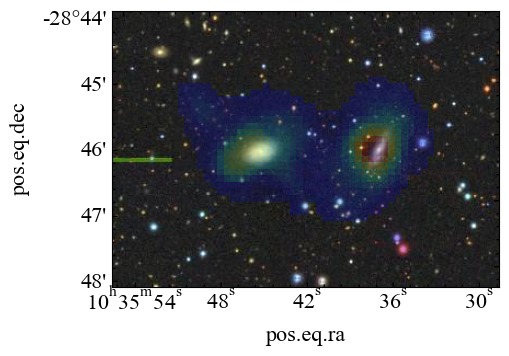

In [3]:
plt.figure(figsize=(5,5))
plt.subplot(111, projection=wcs)
plt.imshow(img, extent=[-.5, w-.5, -.5, h-.5])
plt.imshow(masked_mom0, alpha=0.2, cmap="jet")

#### Image cut

- If the sources only exist at the center of the image, we may wish to cut the data to speed up following procedures:

In [ ]:
def center_cut(margin=0):
    '''
    clip the data if sources only exist at the central region.
    
    Parameters
    ----------
    margin : int. The number of pixels at the edge of the HI cube to be deleted. 

    Returns
    -------
    All cube/image/wcs after the cut.
    '''
    # cut HI data cubes
    cube_cut = cube.copy()
    mask_cut = mask.copy()
    cube_cut[0].data = cube_cut[0].data[:, margin:h-margin, margin:w-margin]
    mask_cut[0].data = mask_cut[0].data[:, margin:h-margin, margin:w-margin]
    
    # cut on optical images
    h1, w1, _ = np.shape(img)
    if min(h1, w1) <= 0:  raise ValueError("Cube size equals to zero.")
    margin_opt = margin * pix
    opti_cut = opti.copy()
    opti_cut[0].data = opti_cut[0].data[:, margin_opt:h1-margin_opt, margin_opt:w1-margin_opt]
    img_cut = img[margin_opt:h1-margin_opt, margin_opt:w1-margin_opt]
    
    # cut moment-0 maps
    mom0_cut        = mom0[margin:h-margin, margin:w-margin]
    masked_mom0_cut = masked_mom0[margin:h-margin, margin:w-margin]
    
    # update wcs
    wcs_cut     = wcs.copy()
    wcs_opt_cut = wcs_opt.copy()
    wcs_cut.wcs.crpix[0]     -= margin; wcs_cut.wcs.crpix[1] -= margin
    wcs_opt_cut.wcs.crpix[0] -= margin*pix; wcs_opt_cut.wcs.crpix[1] -= margin*pix

    return cube_cut, mask_cut, opti_cut, img_cut, mom0_cut, masked_mom0_cut, wcs_cut, wcs_opt_cut, *cube_cut[0].data.shape

# run this if you want to cut your data
# cube, mask, opti, img, mom0, masked_mom0, wcs, wcs_opt, z, h, w = center_cut(0)

## 2. Optical sources

- If you have the photometric info for the sources to deblend, please SKIP to **Section 2.3**. 

### 2.1 Generate star masks using Gaia DR3 catalog  

As the first step, we mask the stars in the optical image using Gaia data.

#### Free Parameters
- **mask size**  
    We use circles to mask the stars in optical images. Here we set the mask radii based on the Gaia RP-band fluxes. Mask dilation may be included in the future. Please feel free to adjust these size parameters.
    
- **Gaia star-galaxy separation**  
    We use an empirical criterion based on Gaia colors to skip galaxies in the Gaia catalog while retaining most of the stars: $\rm G - 0.4G_{RP}-0.6G_{BP} > 0.3$. A better way to do this is to download the Gaia catalog containing the 'ruwe' parameter [here](https://gea.esac.esa.int/archive/), then using the criterion $\rm ruwe > 1.4$.

In [ ]:
from astroquery.gaia import Gaia

Gaia.MAIN_GAIA_TABLE = "gaiadr3.gaia_source"
Gaia.ROW_LIMIT = -1

# Run astroquery.
# This may take some time for large images. 
# In such case, you can save this table and reload it next time.
gaia_table = Gaia.query_object_async(coords, width=w/3000*pix*u.deg, height=h/3000*pix*u.deg)

# generate star masks
star_mask  = np.zeros_like(opti[0].data[0]).astype(np.int8)

for star in gaia_table:
    star_coord = SkyCoord(ra=star["ra"], dec=star["dec"],
                          unit=(u.degree, u.degree), frame='icrs')
    star_pixel = wcs_opt.world_to_pixel(star_coord)
    y_pix, x_pix = int(star_pixel[1]), int(star_pixel[0])
    
    # Gaia star-galaxy separation: skip galaxies 
    if star["phot_g_mean_mag"]-0.4*star["phot_rp_mean_mag"]-0.6*star["phot_bp_mean_mag"] > 0.3:
        continue
        
    # mask radius = r
    # You may adjust these numbers according to your data
    try: r = int((star["phot_rp_mean_flux"])**0.1) * 3 + 1
    except: r = 2
    
    # add a circle to the mask
    for i in range(y_pix-r, y_pix+r):
        for j in range(x_pix-r, x_pix+r):
            if (j - x_pix)**2 + (i - y_pix)**2 < r**2:
                try: 
                    star_mask[i][j] = 1
                except: pass
                    
# ~ 10 seconds to finish for the demo

### 2.2. source detection on optical images

We use the source detection results on optical images as "priors" for the 3D deblending on HI data cubes. So a significant overlap between the stellar components and their corresponding HI detections is required. Otherwise, you may have to set the labels manually. 

#### Free Parameters
parameters of [_photutils.segmentation.detect_sources_](https://photutils.readthedocs.io/en/stable/api/photutils.segmentation.detect_sources.html) and [_photutils.segmentation.deblend_sources_](https://photutils.readthedocs.io/en/stable/api/photutils.segmentation.deblend_sources.html):
   - **detect threshold:** nsigma=3 
   - **smooth kernel:** make_2dgaussian_kernel(fwhm=4, size=21) [pixel]
   - nlevels=16, contrast=0.1, npixel=300

In [ ]:
from astropy.convolution import convolve
from photutils.segmentation import detect_threshold, detect_sources, deblend_sources, make_2dgaussian_kernel

# optical image data
data = np.ma.masked_array(opti[0].data[0],star_mask==1)
data = opti[0].data[0]
data[star_mask==1] = 0

# source detection and deblending using photutils. 
## feel free to adjust the following parameters for better source detection. ##
threshold = detect_threshold(data, nsigma=3)
fwhm = 3
kernel = make_2dgaussian_kernel(fwhm, size=13)

npixels = 300

data_smooth = convolve(data, kernel) # smoothed optical images

segm = detect_sources(data_smooth, threshold, npixels=npixels)
segm_deblend = deblend_sources(data_smooth, segm, npixels=npixels, nlevels=16, contrast=0.1)

# try to reduce the value of npixel if only one source is detected
while np.max(segm_deblend) < 2:
    npixels -= 10
    segm = detect_sources(data_smooth, threshold, npixels=npixels)
    segm_deblend = deblend_sources(data_smooth, segm, npixels=npixels, nlevels=16, contrast=0.1)

# deblending results with background masked
masked_deb = np.ma.masked_array(segm_deblend, np.abs(segm_deblend) < 1e-8)

# show the results
plt.figure(figsize=(18,6))
plt.subplot(131)
plt.imshow(np.cbrt(data), vmin=-.1, vmax=.5)
plt.subplot(132)
plt.imshow(segm, cmap=segm.cmap)
plt.subplot(133)
plt.imshow(masked_deb, cmap=segm_deblend.cmap)
plt.imshow(np.cbrt(data), alpha=.7, cmap="Greys", vmin=-.1, vmax=.6)

### 2.3 using source catalogs

If you have galaxy coordinate & shape info from catalogs, you can directly initialize the 2D markers without the source detection steps.  
Here's an example:

In [4]:
from astropy.table import Table
from photutils.aperture import EllipticalAperture, CircularAperture
from astropy.convolution import convolve
from photutils.segmentation import make_2dgaussian_kernel

# input source table (e.g., SGA2020)
src_table = Table(names=['ra', 'dec', 'PA', 'sma', 'e'],
                  data=np.array([[158.9368, -28.7691, 107.8, 23.8, 0.36], 
                                 [158.9026, -28.7686, 154.7, 24.7, 0.65]]))

masked_deb = np.full((h*pix, w*pix), 0)
pix_opt = wcs_opt.wcs.cd[1][1] * 3600
kernel  = make_2dgaussian_kernel(fwhm=1, size=13)
data    = opti[0].data[0].copy()
data_smooth = convolve(data, kernel)

for i in range(len(src_table)):
    gal_coord = SkyCoord(ra=src_table["ra"][i], dec=src_table["dec"][i], unit='deg')
    xcen, ycen = wcs_opt.world_to_pixel(gal_coord)
    aper = EllipticalAperture((xcen/pix, ycen/pix), 
                              a=src_table["sma"][i] / pix_opt, 
                              b=src_table["sma"][i] * (1-src_table["e"][i]) / pix_opt, 
                              theta=(90+src_table["PA"][i])*u.deg)
    segment = aper.to_mask(method='center')
    masked_deb[int(ycen)-segment.shape[0]//2+1:int(ycen)+1-segment.shape[0]//2+segment.shape[0],
               int(xcen)-segment.shape[1]//2+1:int(xcen)+1-segment.shape[1]//2+segment.shape[1]] = segment.data * (i + 1)

## 3. deblending of the moment-0 map (2D)

We use the traditional watershed algorithm to deblend galaxy pairs. The results of this 2D method are similar to the 3D methods below when the separation between galaxies is large enough (see Figure 11 in the paper). It also helps us to test the code quickly. 

In this step, we run the watershed algorithm twice. After the first run, markers that grow less than a threshold (_min_growth_ pixels) in area are removed, as they are very likely to be contaminant sources.

#### Free Parameters
- **find central regions**
   - make_2dgaussian_kernel(fwhm=3, size=15): the kernel to smooth the optical image
   - thresh=0: within each segment of the deblending results above, pixels with **[flux > mean + std * thresh]** are set as the marker
- **mom0_ext**  
    smooth the moment-0 map or not (in line 28, not important)
- **threshold of the minimal growth**  
    min_growth = 5*pix^2
- **use_extend**  
    whether to oversample the HI data to match the resolution of optical images. The default is False.

In [5]:
use_extend = False

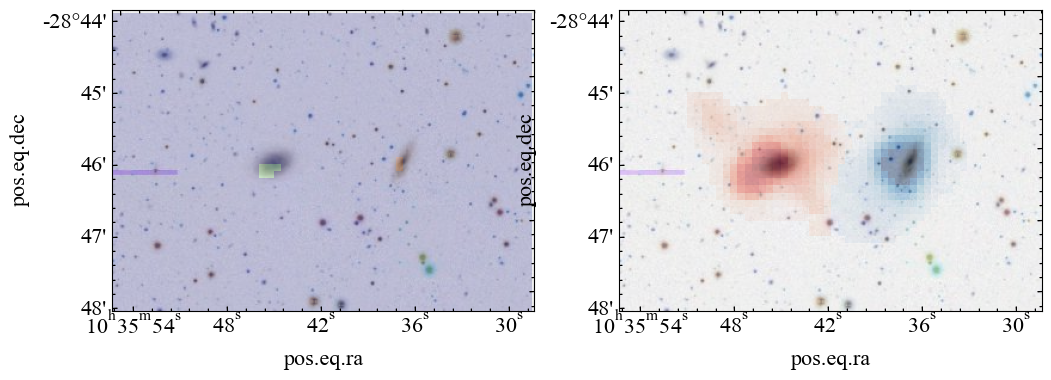

In [6]:
# ----------- initialize markers ---------
from utils.cube_utils import *

mom0_ext = extend(mom0, num=pix, smooth=True) if use_extend else mom0

# find the central regions of galaxies and set them as markers
markers_opt = np.zeros_like(opti[0].data[0]).astype(np.int8)
for i in np.unique(masked_deb):
    if i == 0 or np.ma.is_masked(i): 
        continue
    thresh = 1.
    segment = (masked_deb == i)
    mean, std = np.mean(data_smooth[segment]), np.std(data_smooth[segment])
    markers_opt[np.logical_and(data_smooth > mean + std * thresh, segment)] = i

if not use_extend:
    # reproject the optical markers to the moment 0 map of HI data
    try:
        from reproject import reproject_interp
        # from scipy.ndimage import label
        markers2d = np.full((h, w), 0)
        for i in np.unique(markers_opt):
            if i == 0 or np.ma.is_masked(i): continue
            marker, _ = reproject_interp((markers_opt == i, wcs_opt), wcs)
            markers2d[marker > 0.5] = i
    except ImportError:
        markers2d = markers_opt[::pix, ::pix]
else:
    markers2d = markers_opt

# ----------- run watershed ----------
from skimage.segmentation import watershed

# initial watershed (res: result)
res2d = watershed(-mom0_ext, markers2d, mask=np.abs(mom0_ext)>1e-6, connectivity=2)

# clean markers that grow less than min_growth pixels
min_growth = 5 * pix**2
for i in np.unique(res2d):
    if i > 0 and np.sum(res2d == i) < np.sum(markers2d == i) + min_growth:
        markers2d[res2d==i] = 0  
        
# rerun watershed
res2d = watershed(-mom0_ext, markers2d, mask=np.abs(mom0_ext)>1e-6, connectivity=2)

# get every segments of the deblend results
segments = []
for i in np.unique(res2d):
    if i > 0:
        segments.append(np.ma.masked_array(mom0_ext, np.abs(res2d-i)>1e-6))

# plot the results
plt.figure(figsize=(12,5))
plt.subplot(121, projection=wcs)
plt.imshow(markers2d, alpha=0.4, cmap="jet")
plt.imshow([255]*3 - img, alpha=0.5, extent=[0,w,0,h])

plt.subplot(122, projection=wcs)
cmaps = ["Reds", "Blues", "Purples", "Greens", "Greys", "Oranges"] * 10
for n, seg in enumerate(segments):
    plt.imshow(seg, cmap=cmaps[n], alpha=0.8)
    plt.clim(-np.max(masked_mom0)/20, np.max(masked_mom0)/1.5)   
plt.imshow([255]*3 - img, alpha=0.5, extent=[0,w,0,h])

In the right panel above, the moment-0 map is sepatated into two components (blue / red).

## 4. 3D deblending

There are two steps to deblend galaxies in a 3D data cube. Both steps apply the watershed algorithm, while their main difference is where the markers are set.

1. **fixed-3D:** in all channels, markers are placed in the same place as in the 2D deblending method.
2. **peak-3D:** find 3D peaks in the smoothed data cube, then assign labels to these peaks according to the result of fixed-3D.

Before running _watershed_, we should smooth the data cube along the frequency axis to increase S/N.

#### Free Parameters
- **smooth kernel**  
    smooth=4.0: the smoothness of data along the frequency axis.
- **peak finder**  
    We modified the function [_photutils.detection.find_peaks_](https://photutils.readthedocs.io/en/stable/api/photutils.detection.find_peaks.html) to make it applicable to 3D arrays. It shares similar parameters as the 2D version.
- **minimum growth**  
    min_growth = z*pix^2: same as that in 2D deblending 

In [10]:
from utils.find_peaks_3d import find_peaks

cube_ext = cube[0].data if not use_extend else extend(cube[0].data, num=pix, smooth=True) 
mask_ext = mask[0].data if not use_extend else extend(mask[0].data, num=pix)

# bin / smooth the data
mask_smooth = mask_ext
cube_smooth = freq_smooth(cube_ext, smooth=4.0)

markers3d = np.zeros_like(cube_smooth).astype(np.int8)

## Step 1: fixed-3D ##
for freq in range(len(cube_smooth)):
    markers3d[freq] = markers2d

res3d0 = watershed(-cube_smooth, markers3d, mask=np.abs(mask_smooth)>1e-6,
                   connectivity=2)

# clean markers that grow less than min_growth pixels in area
min_growth = pix**2 * z
for i in np.unique(res3d0):
    if i > 0 and np.sum(res3d0 == i) < np.sum(markers3d == i) + min_growth:
        markers3d[res3d0==i] = 0

res3d0 = watershed(-cube_smooth, markers3d, mask=np.abs(mask_smooth)>1e-6,
                   connectivity=2)
    
## Step 2: peak-3D ##
threshold = np.zeros_like(cube_smooth) + np.nanstd(cube_smooth) * 3
peaks = find_peaks(cube_smooth, threshold, box_size=10, npeaks=10,      # this is fragile at the moment ...
                   mask=np.abs(mask_smooth)<1e-6)

markers3d[:] = 0  # reset markers
for peak in peaks:
    i,j,k = peak["z_peak"], peak["y_peak"], peak["x_peak"]
    # place markers in the vicinity of the flux peaks
    markers3d[i-2:i+2,j-1:j+1,k-1:k+1] = res3d0[i-2:i+2,j-1:j+1,k-1:k+1]
    # you can add some markers manually 
    # (manual markers here ...)

res3d = watershed(-cube_smooth, markers3d, mask=np.abs(mask_smooth)>1e-6)

# if you want to change back to the fixed-3D results, simply use:
# res3d = res3d0.copy()

# we have finished, now just re-arrange the indices.
for n, i in enumerate(np.unique(res3d)):
    res3d[res3d == i] = n

# running this cell takes a long time for large data cubes.
# ~ 10 seconds to finish for the demo

Now we have three deblending results (2D: _res2d_, fixed-3D: _red3d0_, peak-3D: _res3d_). Generally, the **peak 3D** method performs the best among all these methods in most cases, and the 2D method generally performs worse than its 3D counterparts.  

These results can be used to derive other properties of galaxies.  
<br></br><br>

## 5. visualization  
Here are some simple ways to take a glance at the deblending results.

#### channel map

In [11]:
from ipywidgets import interact

@interact(channel=(0, len(cube_smooth) - 1))
def plot_cube(channel):
    plt.figure(figsize=(12,6))

    plt.subplot(121, projection=wcs)
    plt.imshow((cube_smooth * mask_smooth)[channel], cmap="gray", extent=[0,w,0,h])
    plt.imshow(np.ma.masked_array(markers3d[channel],markers3d[channel]==0),
               cmap="autumn", extent=[0,w,0,h])

    plt.subplot(122, projection=wcs)
    plt.imshow(res3d[channel], cmap="jet", extent=[0,w,0,h])
    plt.clim(0, np.max(res3d)+1)
    plt.imshow([255] * 3 - img, alpha=0.7, extent=[0,w,0,h])
    _pix = pix if use_extend else 1  # only used for plotting
    plt.scatter(peaks["x_peak"]/_pix, peaks["y_peak"]/_pix, c="r", s=10)
    plt.legend(("HI peaks",))

interactive(children=(IntSlider(value=53, description='channel', max=107), Output()), _dom_classes=('widget-in…

#### deblended moment-0 maps

- Plot the momrnt-0 maps for the two deblended galaxies separately.

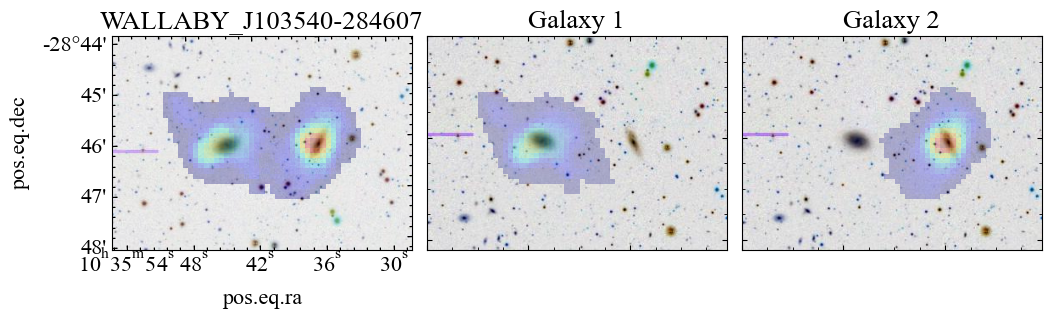

In [12]:
segments3d = []
for i in np.unique(res3d):
    if i > 0:
        segments3d.append([np.ma.masked_array(cube_smooth, np.abs(res3d-i)>0.1), i])
L = len(segments3d) + 1

plt.figure(figsize=(L * 4, 4))
plt.subplots_adjust(wspace=0.05)

plt.subplot(1, L, 1, projection=wcs)
plt.imshow(masked_mom0, alpha=0.9, cmap="jet", extent=[0,w,0,h])
plt.clim(0, np.max(masked_mom0))
plt.imshow([255] * 3 - img, alpha=0.7, extent=[0,w,0,h])
plt.title(name)

for n, seg3d in enumerate(segments3d):
    plt.subplot(1, L, n+2)
    plt.title(f"Galaxy {seg3d[1]}")
    ax = plt.gca()
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    plt.imshow([255] * 3 - img, extent=[0,w,h,0])
    plt.imshow(np.nansum(seg3d[0], axis=0), cmap="jet", alpha=0.25, origin="lower", extent=[0,w,h,0])
    plt.clim(0, np.max(masked_mom0))

#### different projections of the cube

/var/folders/00/2yrskd3n7sn998vb8h_qcq9m0000gn/T/ipykernel_1472/418676439.py:15: RuntimeWarning: invalid value encountered in divide
  plt.imshow(np.nansum(res3d, axis=0) / np.nansum(res3d > 0, axis=0), cmap="jet", extent=[0,w,0,h])
/var/folders/00/2yrskd3n7sn998vb8h_qcq9m0000gn/T/ipykernel_1472/418676439.py:18: RuntimeWarning: invalid value encountered in divide
  plt.pcolor(np.nansum(res3d, axis=1) / np.nansum(res3d > 0, axis=1), cmap="jet")
/var/folders/00/2yrskd3n7sn998vb8h_qcq9m0000gn/T/ipykernel_1472/418676439.py:21: RuntimeWarning: invalid value encountered in divide
  plt.pcolor((np.nansum(res3d, axis=2) / np.nansum(res3d > 0, axis=2)).T, cmap="jet")
/var/folders/00/2yrskd3n7sn998vb8h_qcq9m0000gn/T/ipykernel_1472/418676439.py:23: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()


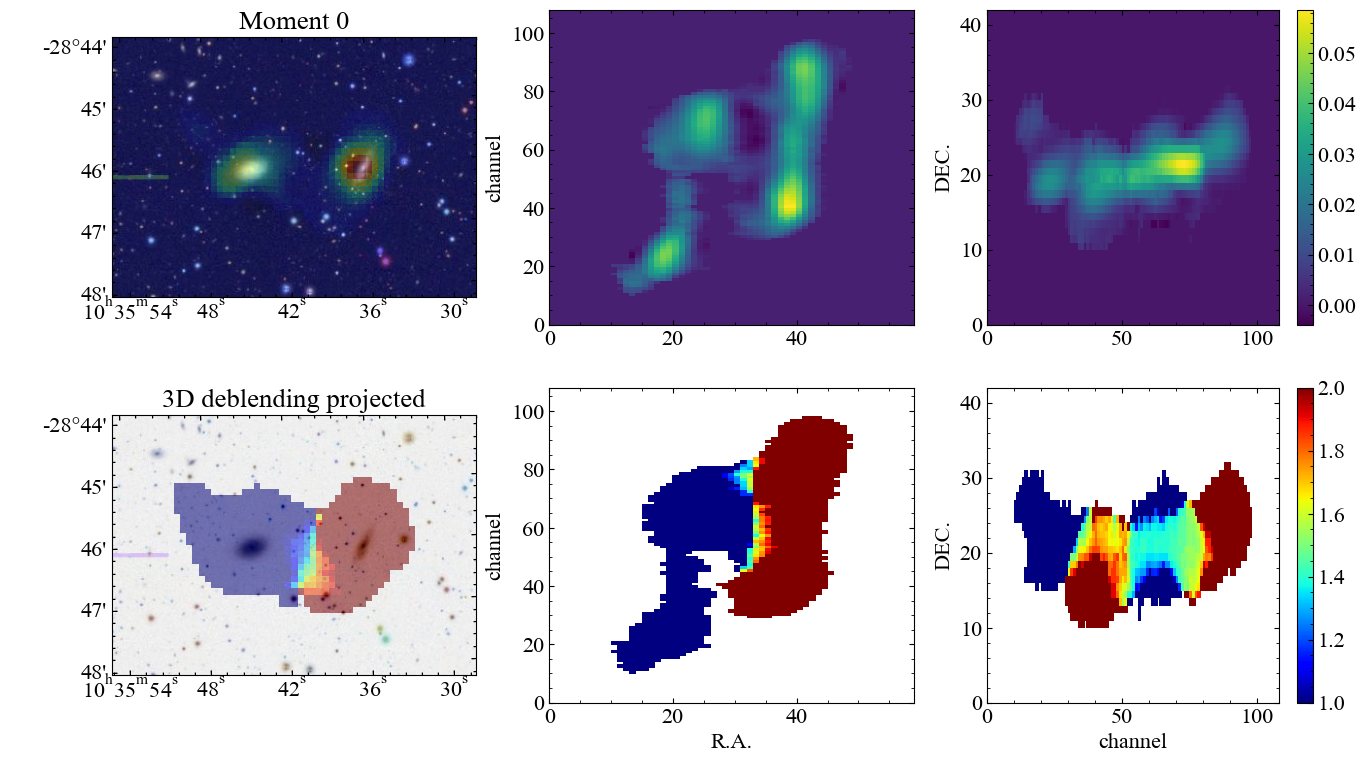

In [13]:
plt.figure(figsize=(16,9))
plt.subplot(231, projection=wcs)
plt.imshow(img, extent=[0,w,0,h])
plt.imshow(np.nansum(mask_smooth * cube_smooth, axis=0), cmap="jet", alpha=0.3, extent=[0,w,0,h])
plt.title("Moment 0"); plt.xlabel(" "); plt.ylabel(" ")
plt.subplot(232)
plt.pcolor(np.nansum(mask_smooth * cube_smooth, axis=1))
plt.ylabel("channel")
plt.subplot(233)
plt.pcolor(np.nansum(mask_smooth * cube_smooth, axis=2).T)
plt.colorbar()
plt.ylabel("DEC.")
plt.subplot(234, projection=wcs)
plt.title("3D deblending projected"); plt.xlabel(" "); plt.ylabel(" ")
plt.imshow(np.nansum(res3d, axis=0) / np.nansum(res3d > 0, axis=0), cmap="jet", extent=[0,w,0,h])
plt.imshow([255] * 3 - img, alpha=.5, extent=[0,w,0,h])
plt.subplot(235)
plt.pcolor(np.nansum(res3d, axis=1) / np.nansum(res3d > 0, axis=1), cmap="jet")
plt.xlabel("R.A."); plt.ylabel("channel")
plt.subplot(236)
plt.pcolor((np.nansum(res3d, axis=2) / np.nansum(res3d > 0, axis=2)).T, cmap="jet")
plt.ylabel("DEC."); plt.xlabel("channel")
plt.colorbar()

## 7. save segmentation

In [ ]:
# save_path = ......
fits.writeto(save_path, res3d, header=cube[0].header, overwrite=True)

<br></br>
#### Get DESI images from https://www.legacysurvey.org/viewer

In [ ]:
from astropy.wcs import WCS

cube = cube        # input data cube
path = "./data"    # path to save the images
layer = "ls-dr10"  # other choices: ls-dr9, sdss, hsc-dr2, unwise-neo7, galex, ...
pixel_scale = 1.0  # in arcsec

# Important: Now the code requires that the spaxel size of the data
#            cube is an **integer multiple** of this pixel_scale. 
# For example, the spaxel size of WALLABY data is 6'', 
# so we use DESI images with pixel_scale = 1''.

pix = round(cube[0].header["CDELT2"] / pixel_scale * 3600)  # pix = 6''/1'' = 6

wcs = WCS(cube[0].header).celestial
z, h, w = np.shape(cube[0].data)   # shape of the data cube
coords = wcs.pixel_to_world(w/2-0.5, h/2-0.5)
ra, dec = coords.ra.value, coords.dec.value

# .fits cutout
url_fits = f"https://www.legacysurvey.org/viewer/cutout.fits?ra={str(ra)}&dec={str(dec)}&layer={layer}&pixscale={str(pixel_scale)}&width={str(w*pix)}&height={str(h*pix)}"
hdul = fits.open(url_fits)
hdul.writeto(path + "/desi.fits", overwrite=True)

# .jpg cutout
import requests
from io import BytesIO

url_jpg = f"https://www.legacysurvey.org/viewer/cutout.jpg?ra={str(ra)}&dec={str(dec)}&layer={layer}&pixscale={str(pixel_scale)}&width={str(w*pix)}&height={str(h*pix)}"
response = requests.get(url_jpg)
Image.open(BytesIO(response.content)).save("./data/desi.jpg", overwrite=True)